<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Alumno: Omar Lopez Cabrera
## Desafio 3 - Predicción de próxima palabra

## Utilizar otro dataset y poner en práctica la generación de secuencias con las estrategias presentadas

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.6 MB/s eta 0:00:00


In [3]:
#levanto el archivo Los_miserables.txt de mi drive en un df
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Los_miserables.txt'



Mounted at /content/drive


In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv(file_path, sep='/n', header=None, engine='python')
df.head()

,0
0,"Los Miserables, de Victor Hugo"
1,Los Miserables
2,Victor Hugo
3,Novela
4,Índice


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 6079


In [6]:
# prompt: me quedo con 1/10 del dataset, sino se queda sin memoria. Tambien probe con google colab pro para tener mas memoria,
#Pero la perplejidad se me va a infinito.

# Tomar una cuarta parte del dataset
df_reduced = df.sample(frac=0.02, random_state=42)  # random_state para reproducibilidad
print("Cantidad de documentos luego de reducir:", df_reduced.shape[0])
df = df_reduced # Reemplaza el df original con el reducido

Cantidad de documentos luego de reducir: 122


### Elegir el tamaño del contexto

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
# cada renglón lo guardamos en una lista
text = list(df.loc[:,0])
text

['—Toma esta carta. Ya sabes lo que tienes que hacer. Abajo hay un cabriolé esperándote, parte de inmediato y vuelve volando.',
 'V. El interior de la desesperación',
 'Había dormido más de cuatro horas. No acos\xadtumbraba dedicar más tiempo al reposo.',
 'Javert repitió a media voz:',
 '—Es un papel que esos señores han dejado abajo para estas señoritas.',
 '—¿Lo habéis traído aquí desde la barricada?',
 'Esta piedra no se halla menos expuesta que las demás a la lepra del tiempo, a los efectos de la humedad, del líquen y de las inmundicias de los pájaros. El agua la pone verde y el aire la enne\xadgrece. No está próxima a ninguna senda, y no es agradable ir a pasear por aquel lado a causa de la altura de la hierba. Cuando la bañan los rayos del sol, se suben a ella los lagartos. A su alrededor se mecen los tallos de avena agitados por el viento, y en la primavera cantan en el árbol las currucas.',
 'Los niños aceptan inmediatamente y con toda naturalidad la alegría y la dicha, siendo

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence, filters='«»¡!"#$%&()*+,-./:;<=>¿?@[\\]^_`{|}~\t\n—') for sentence in text]

In [9]:
text[0]

'—Toma esta carta. Ya sabes lo que tienes que hacer. Abajo hay un cabriolé esperándote, parte de inmediato y vuelve volando.'

In [10]:
segmented_sentences[0]

['toma',
 'esta',
 'carta',
 'ya',
 'sabes',
 'lo',
 'que',
 'tienes',
 'que',
 'hacer',
 'abajo',
 'hay',
 'un',
 'cabriolé',
 'esperándote',
 'parte',
 'de',
 'inmediato',
 'y',
 'vuelve',
 'volando']

In [11]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

In [12]:
print(set(length_sentences))  # Muestra los valores únicos

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 26, 28, 29, 30, 31, 32, 33, 36, 38, 40, 43, 44, 47, 51, 53, 60, 62, 63, 64, 67, 76, 77, 78, 79, 97, 98, 100, 122}


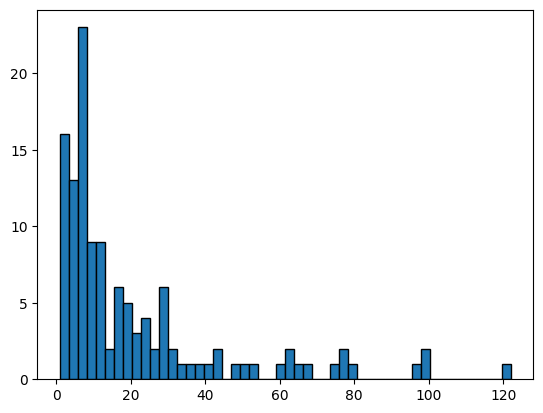

In [13]:
# podemos ver su distribución
# Filtrar los valores distintos de 0
length_sentences_non_zero = [length for length in length_sentences if length > 0]

# Crear el histograma
plt.hist(length_sentences_non_zero, bins=50, edgecolor='black')
plt.show()

In [14]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90) - 1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 58


###  Tokenizar

In [15]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [16]:
tokenized_sentences[0]

[267,
 30,
 41,
 90,
 268,
 13,
 4,
 91,
 4,
 140,
 92,
 141,
 12,
 269,
 270,
 71,
 1,
 271,
 3,
 272,
 273]

In [17]:
segmented_sentences[0]

['toma',
 'esta',
 'carta',
 'ya',
 'sabes',
 'lo',
 'que',
 'tienes',
 'que',
 'hacer',
 'abajo',
 'hay',
 'un',
 'cabriolé',
 'esperándote',
 'parte',
 'de',
 'inmediato',
 'y',
 'vuelve',
 'volando']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [19]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [20]:
len(tok_sent)

310

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:
- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [21]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [22]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [23]:
train_seqs.shape

(14099, 59)

In [24]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [25]:
y.shape

(14099, 58)

In [26]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'que',
 5: 'a',
 6: 'el',
 7: 'en',
 8: 'se',
 9: 'no',
 10: 'los',
 11: 'con',
 12: 'un',
 13: 'lo',
 14: 'una',
 15: 'su',
 16: 'es',
 17: 'había',
 18: 'sus',
 19: 'para',
 20: 'las',
 21: 'por',
 22: 'dijo',
 23: 'al',
 24: 'le',
 25: 'todo',
 26: 'tenía',
 27: 'qué',
 28: 'thenardier',
 29: 'pero',
 30: 'esta',
 31: 'del',
 32: 'sin',
 33: 'mi',
 34: 'estaba',
 35: 'cosette',
 36: 'ojos',
 37: 'marius',
 38: 'hacia',
 39: 'él',
 40: 'madre',
 41: 'carta',
 42: 'más',
 43: 'aquí',
 44: 'aquel',
 45: 'parís',
 46: 'allí',
 47: 'hombre',
 48: 'fue',
 49: 'si',
 50: 'señor',
 51: 'menos',
 52: 'cuando',
 53: 'ella',
 54: 'me',
 55: 'algo',
 56: 'muy',
 57: 'dos',
 58: 'eso',
 59: 'sí',
 60: 'después',
 61: 'entonces',
 62: 'también',
 63: 'otro',
 64: 'siempre',
 65: 'decía',
 66: 'puerta',
 67: 'niña',
 68: 'jean',
 69: 'valjean',
 70: 'ha',
 71: 'parte',
 72: 'voz',
 73: 'aire',
 74: 'eponina',
 75: 'yo',
 76: 'o',
 77: 'tres',
 78: 'visto',
 79: 'jo

In [27]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1056

In [28]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'y': 3, 'que': 4, 'a': 5, 'el': 6, 'en': 7, 'se': 8, 'no': 9, 'los': 10, 'con': 11, 'un': 12, 'lo': 13, 'una': 14, 'su': 15, 'es': 16, 'había': 17, 'sus': 18, 'para': 19, 'las': 20, 'por': 21, 'dijo': 22, 'al': 23, 'le': 24, 'todo': 25, 'tenía': 26, 'qué': 27, 'thenardier': 28, 'pero': 29, 'esta': 30, 'del': 31, 'sin': 32, 'mi': 33, 'estaba': 34, 'cosette': 35, 'ojos': 36, 'marius': 37, 'hacia': 38, 'él': 39, 'madre': 40, 'carta': 41, 'más': 42, 'aquí': 43, 'aquel': 44, 'parís': 45, 'allí': 46, 'hombre': 47, 'fue': 48, 'si': 49, 'señor': 50, 'menos': 51, 'cuando': 52, 'ella': 53, 'me': 54, 'algo': 55, 'muy': 56, 'dos': 57, 'eso': 58, 'sí': 59, 'después': 60, 'entonces': 61, 'también': 62, 'otro': 63, 'siempre': 64, 'decía': 65, 'puerta': 66, 'niña': 67, 'jean': 68, 'valjean': 69, 'ha': 70, 'parte': 71, 'voz': 72, 'aire': 73, 'eponina': 74, 'yo': 75, 'o': 76, 'tres': 77, 'visto': 78, 'jondrette': 79, 'viaje': 80, 'vez': 81, 'así': 82, 'algunos': 83, 'algunas': 84, 'añ

In [29]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'esta': 8, 'cabriolé': 1, 'tienes': 3, 'lo': 21, 'carta': 5, 'ya': 3, 'hay': 2, 'un': 23, 'inmediato': 1, 'vuelve': 1, 'abajo': 3, 'hacer': 2, 'parte': 3, 'que': 39, 'de': 50, 'sabes': 1, 'esperándote': 1, 'volando': 1, 'toma': 1, 'y': 55, 'v': 1, 'el': 48, 'interior': 1, 'desesperación': 2, 'la': 42, 'horas': 2, 'tiempo': 3, 'acos\xadtumbraba': 1, 'reposo': 1, 'cuatro': 2, 'dormido': 2, 'dedicar': 1, 'había': 12, 'no': 24, 'al': 11, 'más': 5, 'repitió': 1, 'media': 1, 'javert': 1, 'voz': 4, 'a': 39, 'señores': 1, 'papel': 1, 'es': 16, 'han': 1, 'dejado': 2, 'esos': 3, 'estas': 1, 'señoritas': 1, 'para': 10, 'aquí': 5, 'desde': 1, 'barricada': 2, 'habéis': 3, 'traído': 1, 'agitados': 1, 'primavera': 1, 'menos': 4, 'del': 5, 'su': 20, 'aire': 4, 'demás': 3, 'avena': 1, 'árbol': 1, 'pone': 1, 'verde': 1, 'piedra': 2, 'tallos': 1, 'alrededor': 1, 'suben': 1, 'lado': 1, 'humedad': 1, 'está': 3, 'por': 14, 'expuesta': 1, 'lagartos': 1, 'se': 31, 'hierba': 1, 'alt

### Funciones a utilizar


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [30]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.model_name}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


In [31]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [32]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [33]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
def plot_model_history(history_ppl, model_name):
  epoch_count = range(1, len(history_ppl) + 1)
  sns.lineplot(x=epoch_count,  y=history_ppl)
  plt.title(model_name)
  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  plt.show()

In [35]:
import gradio as gr

def model_response(model, human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

def predict_with_gradio(model):
    iface = gr.Interface(
        fn=lambda text: model_response(model, text),
        inputs=["textbox"],
        outputs="text")

    iface.launch(debug=True)

### Modelo 1: Simple RNN

In [36]:
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
model1 = Sequential()

# Capa de embedding entrenable
model1.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# SimpleRNN
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(128, return_sequences=True))
model1.add(Dropout(0.2))

# Predicción de clasificación con softmax
model1.add(Dense(vocab_size+1, activation='softmax'))

model1.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │          67,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 1057)          │         136,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261,601 (1021.88 KB)

 Trainable params: 261,601 (1021.88 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [37]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
import time

history_ppl1 = []
model1_name = "SimpleRNN"

# Inicia el temporizador
start_time = time.time()

# Entrena el modelo
hist1 = model1.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl1, model1_name)],
    batch_size=64
)

# Calcula el tiempo transcurrido+
training_time_SimpleRNN = time.time() - start_time

# Imprime el tiempo de entrenamiento
print(f"Tiempo de entrenamiento para {model1_name}: {training_time_SimpleRNN:.2f} segundos")

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3304
 mean perplexity: 264525.1178739976 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 3.3270
Epoch 2/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1950
 mean perplexity: 527246.865979942 

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 1.1912
Epoch 3/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4927
 mean perplexity: 482725.72717784415 

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.4921
Epoch 4/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3521
 mean perplexity: 441584.6964412978 

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.3518
Epoch 5/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2981
 mean perplexity: 426468.2237920836 

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2980
Epoch 6/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2619
 mean perplexity: 587794.233422177 

Stopping training...
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step

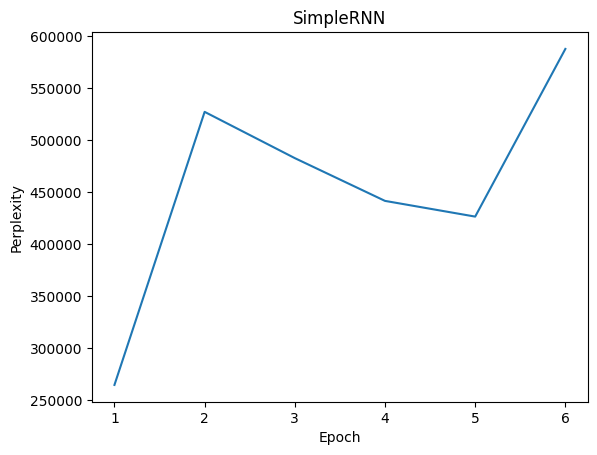

In [38]:
plot_model_history(history_ppl1, model1_name)

In [39]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model1 = keras.models.load_model(f'{model1_name}.keras')

Hacemos predict de una palabra

In [40]:
predict_with_gradio(model1)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://040682048afb3bab92.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://040682048afb3bab92.gradio.live


#### Generación de secuencias

In [41]:
input_text='Las costumbres de los'

generate_seq(model1, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Las costumbres de los la tenga siempre está próxima a ninguna senda y no'

In [42]:
input_text='Los Thenardier se habían instalado'
generate_seq(model1, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Los Thenardier se habían instalado la pone en la leyó que la tiró hecha cuatro'

Los textos predichos no tienen mucha coherencia

####  Beam search y muestreo aleatorio

In [43]:
temps = [1, 10, 15]
num_beams_list = [3, 4, 5]  # Lista con los valores para el número de "beams"

for temp in temps:
    for num_beams in num_beams_list:
        print(f"Temperatura: {temp}, Número de beams: {num_beams}")
        salidas = beam_search(model1, num_beams=num_beams, num_words=6, input="Los Thenardier", temp=temp, mode='sto')
        for idx, salida in enumerate(salidas):
            print(f"Salida {idx + 1}: {decode(salida)}")
        print()

Temperatura: 1, Número de beams: 3
Salida 1: ['los thenardier se en en no está próxima']
Salida 2: ['los thenardier se en en no próxima al']
Salida 3: ['los thenardier se en en no próxima cruzó']

Temperatura: 1, Número de beams: 4
Salida 1: ['los thenardier no está temblando los sus por']
Salida 2: ['los thenardier no está temblando los sus desfigurada']
Salida 3: ['los thenardier no está temblando los sus seis']
Salida 4: ['los thenardier no está temblando los sus lo']

Temperatura: 1, Número de beams: 5
Salida 1: ['los thenardier las sobre de la niña es']
Salida 2: ['los thenardier las sobre de la niña del']
Salida 3: ['los thenardier las sobre de la niña de']
Salida 4: ['los thenardier las sobre de la sombra fue']
Salida 5: ['los thenardier las sobre de la niña lo']

Temperatura: 10, Número de beams: 3
Salida 1: ['los thenardier verá sus padre seis colores silenciosa']
Salida 2: ['los thenardier verá sus padre enormes forastera sangre']
Salida 3: ['los thenardier verá sus padre eno

### Modelo 2: LSTM_1



In [44]:

model2 = Sequential()

# Capa de embedding entrenable
model2.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# SimpleRNN
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))

# Predicción de clasificación con softmax
model2.add(Dense(vocab_size+1, activation='softmax'))

model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 64)            │          67,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1057)          │         136,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 434,401 (1.66 MB)

 Trainable params: 434,401 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [45]:
import time

# Variable para almacenar los valores de perplejidad
history_ppl2 = []
model2_name = "LSTM1"

# Inicia el temporizador
start_time = time.time()

# Entrenamiento del modelo
hist2 = model2.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl2, model2_name)],
    batch_size=64
)

# Calcula el tiempo de entrenamiento
training_time_LSTM1 = time.time() - start_time

# Imprime el tiempo de entrenamiento
print(f"Tiempo de entrenamiento para {model2_name}: {training_time_LSTM1 :.2f} segundos")

Epoch 1/20
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5893
 mean perplexity: 387714.2880281776 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 3.5745
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5396
 mean perplexity: 540016.2177144358 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.5392
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1926
 mean perplexity: 525567.8536032195 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1922
Epoch 4/20
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8442
 mean perplexity: 566203.4016757486 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.8423
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5019
 mean perplexity: 627850.7246419685 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5016
Epoch 6/20
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2116
 mean perplexity: 249059.05794052803 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - 

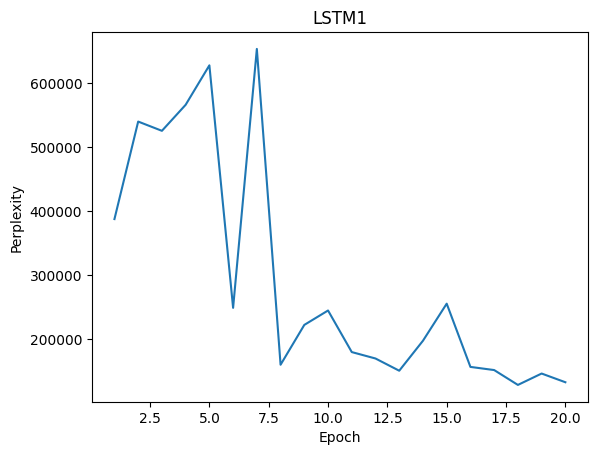

In [46]:
plot_model_history(history_ppl2, model2_name)

In [47]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model2 = keras.models.load_model(f'{model2_name}.keras')

#### Predicción de próxima palabra

In [48]:
predict_with_gradio(model2)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dc3cf74a25a218e47f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://dc3cf74a25a218e47f.gradio.live


#### Generación de secuencias

In [49]:
input_text='Los Thenardier estan'

generate_seq(model2, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Los Thenardier estan contestaban siempre cosette está per\xadfectamente transcurridos los seis primeros me\xadses'

####  Beam search y muestreo aleatorio LSTM1

In [50]:
temps = [1, 10, 15]
num_beams_list = [3, 4, 5]  # Lista con los valores para el número de "beams"

for temp in temps:
    for num_beams in num_beams_list:
        print(f"Temperatura: {temp}, Número de beams: {num_beams}")
        salidas = beam_search(model1, num_beams=num_beams, num_words=6, input="Los Thenardier", temp=temp, mode='sto')
        for idx, salida in enumerate(salidas):
            print(f"Salida {idx + 1}: {decode(salida)}")
        print()

Temperatura: 1, Número de beams: 3
Salida 1: ['los thenardier brillo a de una enne\xadgrece en']
Salida 2: ['los thenardier brillo a de una enne\xadgrece verde']
Salida 3: ['los thenardier brillo a de una altura otro']

Temperatura: 1, Número de beams: 4
Salida 1: ['los thenardier de la mirada del la próxima']
Salida 2: ['los thenardier de la mirada del la tosía']
Salida 3: ['los thenardier de la humedad del triste que']
Salida 4: ['los thenardier de la mirada del la esperanza']

Temperatura: 1, Número de beams: 5
Salida 1: ['los thenardier sin su de la altura con']
Salida 2: ['los thenardier sin su de la señorita al']
Salida 3: ['los thenardier sin su de la señorita del']
Salida 4: ['los thenardier sin su de la altura para']
Salida 5: ['los thenardier sin su de la señorita aleja']

Temperatura: 10, Número de beams: 3
Salida 1: ['los thenardier preocupara guardado árboles ama luz esté']
Salida 2: ['los thenardier años muy había fueron corrompida traído']
Salida 3: ['los thenardier preo

Definir el modelo 2: LSTM_2

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Define the model with different hyperparameters
embedding_dim = 300  # Embedding dimension
lstm_units = 100     # Number of LSTM units
dropout_rate = 0.3   # Dropout rate
learning_rate = 0.001  # Learning rate
batch_size = 64      # Batch size
epochs = 30          # Number of epochs

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_shape=(None,)))
model3.add(LSTM(lstm_units, return_sequences=True))
model3.add(Dropout(dropout_rate))
model3.add(LSTM(lstm_units, return_sequences=True))
model3.add(Dropout(dropout_rate))
model3.add(Dense(vocab_size+1, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = RMSprop(learning_rate=learning_rate)
model3.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Entrenamiento

In [65]:
import time

# Variable para almacenar los valores de perplejidad
history_ppl3 = []
model3_name = "LSTM2"

# Inicia el temporizador
start_time = time.time()

# Entrenamiento del modelo
hist3 = model3.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl3, model3_name)],
    batch_size=64
)

# Calcula el tiempo de entrenamiento
training_time_LSTM2 = time.time() - start_time

# Imprime el tiempo de entrenamiento
print(f"Tiempo de entrenamiento para {model3_name}: {training_time_LSTM2:.2f} segundos")

Epoch 1/20
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5296
 mean perplexity: 918021.1932454164 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2.5271
Epoch 2/20
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1219
 mean perplexity: 1426448.5589095685 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1189
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7441
 mean perplexity: 1187337.8762451285 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.7437
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4012
 mean perplexity: 1060712.529126151 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.4009
Epoch 5/20
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1543
 mean perplexity: 1063250.2818808756 

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.1528
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9416
 mean perplexity: 1088114.6402842554 

Stopping training...
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/

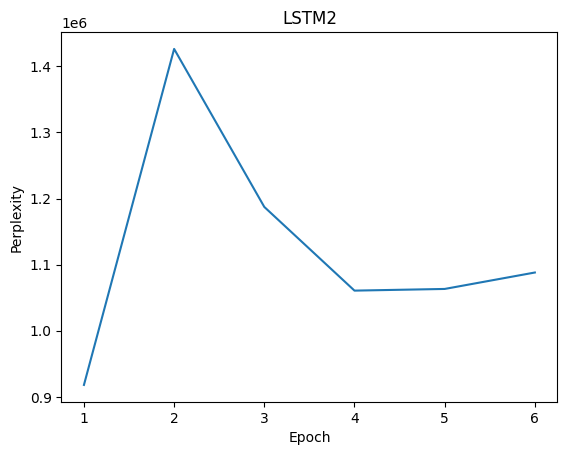

In [66]:
plot_model_history(history_ppl3, model3_name)

In [67]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model3 = keras.models.load_model(f'{model3_name}.keras')

Predict proxima palabra

In [68]:
predict_with_gradio(model3)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a482e7128a13e6efeb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a482e7128a13e6efeb.gradio.live


Generacion secuencia

In [69]:
input_text='Los Thenardier estan'

generate_seq(model3, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Los Thenardier estan se a a a la a a a la a'

####  Beam search y muestreo aleatorio LSTM2

In [71]:
temps = [1, 10, 15]
num_beams_list = [3, 4, 5]  # Lista con los valores para el número de "beams"

for temp in temps:
    for num_beams in num_beams_list:
        print(f"Temperatura: {temp}, Número de beams: {num_beams}")

        # Pasa el modelo entrenado, no el nombre
        salidas = beam_search(model3, num_beams=num_beams, num_words=6, input="Los Thenardier", temp=temp, mode='sto')

        for idx, salida in enumerate(salidas):
            print(f"Salida {idx + 1}: {decode(salida)}")

Temperatura: 1, Número de beams: 3
Salida 1: ['los thenardier en tres se siempre hijas mi']
Salida 2: ['los thenardier en tres se siempre tiempo cada']
Salida 3: ['los thenardier en tres se siempre hijas']
Temperatura: 1, Número de beams: 4
Salida 1: ['los thenardier se a triste de de la']
Salida 2: ['los thenardier se a triste de los se']
Salida 3: ['los thenardier se a triste de de pensar']
Salida 4: ['los thenardier se a triste de los la']
Temperatura: 1, Número de beams: 5
Salida 1: ['los thenardier madre a que el el thenardier']
Salida 2: ['los thenardier madre a que a el discreción']
Salida 3: ['los thenardier madre a que a el hermoso']
Salida 4: ['los thenardier madre a que el el un']
Salida 5: ['los thenardier madre a que el puerta fría']
Temperatura: 10, Número de beams: 3
Salida 1: ['los thenardier pasos materia decrece d enjolras pueden']
Salida 2: ['los thenardier pasos materia decrece d callejuela inmóvil']
Salida 3: ['los thenardier pasos materia decrece d callejuela murm


### Modelo 4: GRU

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Modelo GRU
model4 = Sequential()

# Capa de embedding entrenable
model4.add(Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=(None,)))

# Capas GRU en lugar de LSTM
model4.add(GRU(128, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(GRU(128, return_sequences=True))
model4.add(Dropout(0.2))

# Predicción de clasificación con softmax
model4.add(Dense(vocab_size+1, activation='softmax'))

# Compilación
model4.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 64)            │          67,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, None, 128)           │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 1057)          │         136,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,569 (1.44 MB)

 Trainable params: 377,569 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [73]:
import time

# Variable para almacenar los valores de perplejidad
history_ppl4 = []
model4_name = "GRU"

# Inicia el temporizador
start_time = time.time()

# Entrenamiento del modelo
hist4 = model4.fit(
    X,
    y,
    epochs=20,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl4, model4_name)],
    batch_size=64
)

# Calcula el tiempo de entrenamiento con el nombre del modelo
training_time_gru = f"{model4_name}: {time.time() - start_time:.2f} segundos"

# Imprime el tiempo de entrenamiento
print(f"Tiempo de entrenamiento para {training_time_gru}")

Epoch 1/20
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3721
 mean perplexity: 277177.91150122765 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.3609
Epoch 2/20
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0552
 mean perplexity: 482440.87981147977 

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0506
Epoch 3/20
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4611
 mean perplexity: 262216.23768186296 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.4598
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0862
 mean perplexity: 333341.93184038694 

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0859
Epoch 5/20
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8462
 mean perplexity: 198960.63719974866 

Saved new model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8459
Epoch 6/20
218/221 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7057
 mean perplexity: 344182.9370455306 

221/221 ━━━━━━━━━━━━━━━

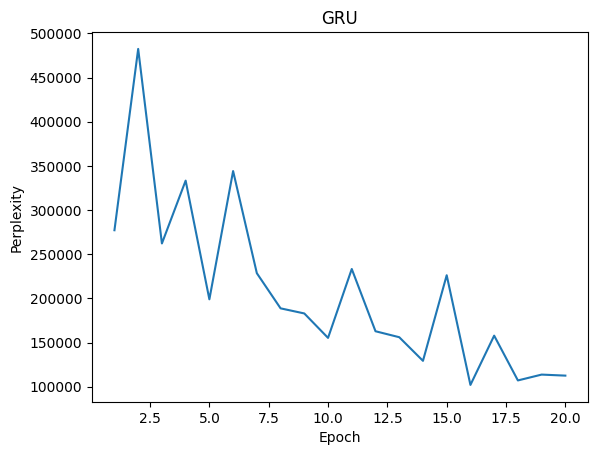

In [74]:
plot_model_history(history_ppl4, model4_name)

In [75]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model4 = keras.models.load_model(f'{model4_name}.keras')


#### Predicción de próxima palabra

In [76]:
predict_with_gradio(model4)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://660e9b21fd9ec95553.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://660e9b21fd9ec95553.gradio.live


#### Generación de secuencias

In [61]:
input_text='Los Thenardier estan'

generate_seq(model2, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Los Thenardier estan contestaban siempre cosette está per\xadfectamente transcurridos los seis primeros me\xadses'

####  Beam search y muestreo aleatorio

In [77]:
temps = [1, 10, 15]
num_beams_list = [3, 4, 5]  # Lista con los valores para el número de "beams"

for temp in temps:
    for num_beams in num_beams_list:
        print(f"Temperatura: {temp}, Número de beams: {num_beams}")
        salidas = beam_search(model4, num_beams=num_beams, num_words=6, input="Los Thenardier", temp=temp, mode='sto')
        for idx, salida in enumerate(salidas):
            print(f"Salida {idx + 1}: {decode(salida)}")
        print()

Temperatura: 1, Número de beams: 3
Salida 1: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 2: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 3: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']

Temperatura: 1, Número de beams: 4
Salida 1: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 2: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 3: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 4: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']

Temperatura: 1, Número de beams: 5
Salida 1: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 2: ['los thenardier contestaban siempre cosette está per\xadfectamente transcurridos']
Salida 3: ['los thenardier contestaban siempre 

### Conclusiones:

Se probaron diferentes modelos para predecir la siguiente palabra, pero todos generaban resultados incoherentes. Se intentó aumentar el tamaño del corpus (actualmente se está utilizando solo el 2%), pero esto provocaba problemas de falta de memoria. Incluso utilizando Colab Pro, al aumentar el porcentaje del corpus, la perplejidad tendía a infinito.